# Analyse de l'écosystème de diffusion de jeux sur Twitch

> *Tendances, statistiques des jeux streamés et hypothèses exploratoires*
>
> **Auteurs**: *Ugo Courche*, *Hadrien Belleville*

## Introduction

La première étape consiste à organiser l'environnement de développement en important pandas et le jeux de données.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Twitch_game_data.csv")
df.head(5)

,Rank,Game,Month,Year,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169.29
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03


Ensuite, nous regardons les types d'objets que nous allons manipuler durant ce rapport.

In [3]:
df.dtypes

Rank                  int64
Game                 object
Month                 int64
Year                  int64
Hours_watched         int64
Hours_streamed        int64
Peak_viewers          int64
Peak_channels         int64
Streamers             int64
Avg_viewers           int64
Avg_channels          int64
Avg_viewer_ratio    float64
dtype: object

On remarque que les colonnes **'Month'** et **'Year'** sont des `int64`. Cela ne posera pas de problème lorsqu'il faudra manipuler uniquement des mois ou des années. Nonobstant il pourrait être intéressant d'avoir une colonne de type `datetime` que nous pourrions utiliser en ayant l'information de l'année et du mois pour ainsi observer des évolutions au mois près durant plusieurs années.

C'est ce que nous faisons dans le bloc suivant où on ajoute une colonne **'Date'** au dataframe en spécifiant le format `'AAAA-MM'` et en ne gardant que la période au mois près (on ne s'occupe pas des jours).

Cette colonne contiendra donc des informations de type `period[M]`, depuis lequel nous pourrons retrouver le format `datetime64` en ajoutant, lorsque nécessaire, l'appel à la fonction `dt.to_timestamp()` sur la colonne **'Date'**.

In [4]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'].astype(str), format='%Y%m').dt.to_period('M')
df[["Game", "Month", "Year", "Date"]].head(3)

,Game,Month,Year,Date
0,League of Legends,1,2016,2016-01
1,Counter-Strike: Global Offensive,1,2016,2016-01
2,Dota 2,1,2016,2016-01


## Exploration des hypothèses

Dans cette section, nous allons traiter nos données afin de répondres aux hypothèses initiales.

### Evolution de la popularité des jeux au fil des mois ou des années

> Faire une normalisation ou lisser en faisant des moyennes au trimestre

#### Influence des pics de spectateurs sur la popularité générale d'un jeu

> Les jeux qui génèrent des pics de spectateurs élevés sont plus susceptibles d'attirer de nouveaux joueurs et de maintenir une base de fans active.

Pour tester l'hypothèse de l'influence des pics de spectateurs sur la popularité générale d'un jeu il faut réussir à mettre en évidence pour un echantillon de jeux si les pics de spectateurs ont une influence sur l'évolution de la popularité des jeux.

Prenons l'exemple de 4 jeux, avec League of Legends, Dota 2, SMITE et Heroes of the Storm. Ces jeux sont 4 MOBA (Multiplayer Online Battle Arena) ayant des communautés très distinctes et des renommées bien différentes.

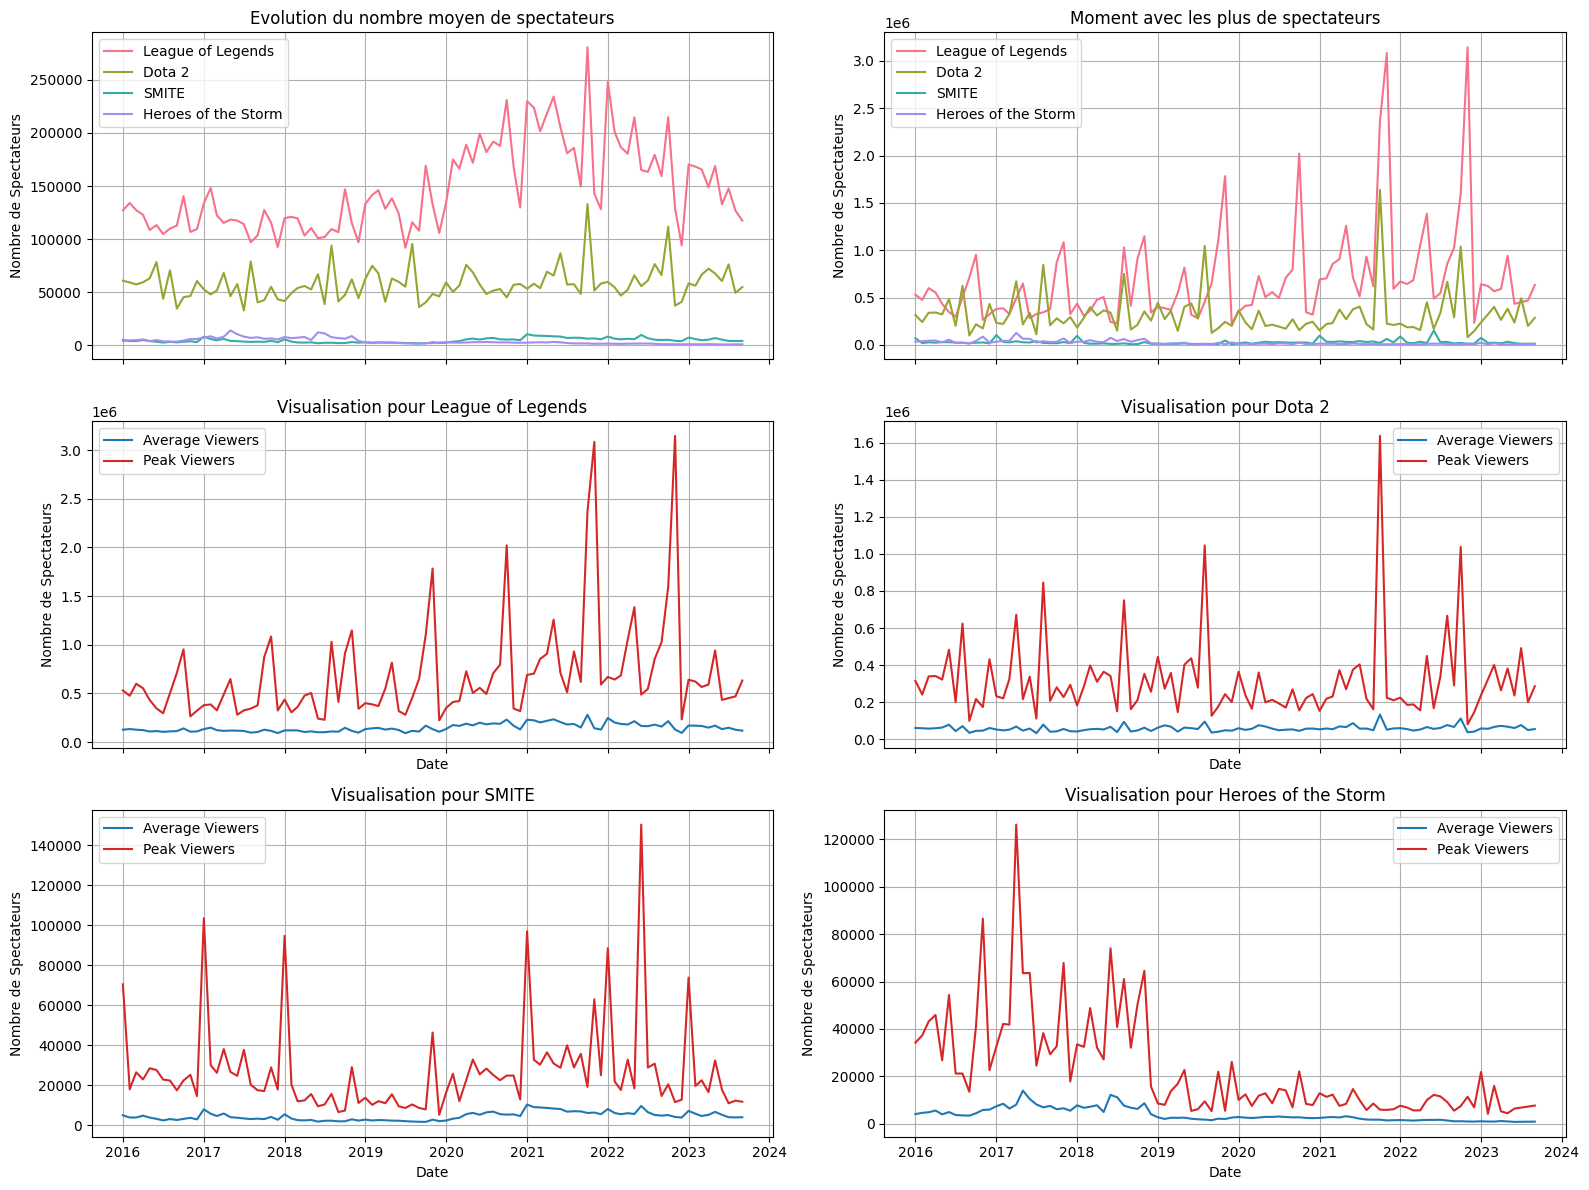

In [5]:
selected_games = ['League of Legends', 'Dota 2', 'SMITE', 'Heroes of the Storm']
selected_data = df[df['Game'].isin(selected_games)]

selected_data = selected_data.sort_values('Date')
selected_data['Date'] = selected_data['Date'].dt.to_timestamp()

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)

axes = axes.flatten()

# Tracé 1 : Evolution du nombre moyen de spectateurs
sns.lineplot(data=selected_data, x='Date', y='Avg_viewers', hue='Game', palette='husl', ax=axes[0])
axes[0].set_title('Evolution du nombre moyen de spectateurs')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Nombre de Spectateurs')
axes[0].legend()
axes[0].grid(True)

# Tracé 2 : Moment avec les plus de spectateurs
sns.lineplot(data=selected_data, x='Date', y='Peak_viewers', hue='Game', palette='husl', ax=axes[1])
axes[1].set_title('Moment avec les plus de spectateurs')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Nombre de Spectateurs')
axes[1].legend()
axes[1].grid(True)

for i, games in enumerate(selected_games):
    lol_data = selected_data[selected_data['Game']==games]
    axes[i+2].plot(lol_data['Date'], lol_data['Avg_viewers'], linestyle='-', label='Average Viewers', color='tab:blue')
    axes[i+2].plot(lol_data['Date'], lol_data['Peak_viewers'], linestyle='-', label='Peak Viewers', color='tab:red')
    axes[i+2].set_title(f'Visualisation pour ' + games)
    axes[i+2].set_xlabel('Date')
    axes[i+2].set_ylabel('Nombre de Spectateurs')
    axes[i+2].legend()
    axes[i+2].grid(True)

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()


Pour ces jeux, le pic de spectateur n'a pas l'air d'avoir une grande influence sur l'évolution des moyennes de spectateurs. Cependant on remarque que les pics de spectateurs augmentent significativement la moyenne de spectateurs lors du mois courant. 

Calculer la correlation entre ces deux variables ainsi que procéder à une étude de la covariance de celles ci nous permettra de mieux évaluer leur relation.

#### Calcul de la correlation

In [6]:
correlation = df['Peak_viewers'].corr(df['Avg_viewers'])
print(f"Corrélation entre peak et avg: {correlation}")

Corrélation entre peak et avg: 0.6939268893343212


La valeur est positive et proche de 0.7. Cela indique une corrélation positive modérée entre ces deux variables. Cela suggère qu'il y a une tendance où lorsque le nombre de pic de spectateurs augmente, le nombre moyen de spectateurs a également tendance à augmenter et vice versa. Nonobstant la force de la corrélation n'est pas très élevée, signifiant que d'autres facteurs peuvent également influencer ces variables.

#### Etude de la covariance

In [7]:
covariance = df['Peak_viewers'].cov(df['Avg_viewers'])
print(f"Covariance entre peak et avg: {covariance}")

Covariance entre peak et avg: 2687163069.788292


La covariance nous indique que les deux variables ont tendance à augmenter ou diminuer ensemble. Cela suggère qu'il existe une tendance commune pour les pics de spectateurs et la moyenne de spectateurs à varier ensemble.

### Relation entre le nombre de streamers et le nombre moyen de spectateurs

### Impact des heures de diffusions sur la popularité d'un jeu

Pour répondre à cette hypothèse, nous allons tout d'abord identifier les variables pouvant être utiliser pour mesurer la popularité.
Dans notre DataFrame, les variables  "Avg_viewers", "Peak_viewers", "Streamers", "Hours_watched" et	"Hours_streamed" peuvent être considérées comme des indicateurs de popularité.

In [8]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18600 entries, 0 to 18599
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   Rank              18600 non-null  int64    
 1   Game              18599 non-null  object   
 2   Month             18600 non-null  int64    
 3   Year              18600 non-null  int64    
 4   Hours_watched     18600 non-null  int64    
 5   Hours_streamed    18600 non-null  int64    
 6   Peak_viewers      18600 non-null  int64    
 7   Peak_channels     18600 non-null  int64    
 8   Streamers         18600 non-null  int64    
 9   Avg_viewers       18600 non-null  int64    
 10  Avg_channels      18600 non-null  int64    
 11  Avg_viewer_ratio  18600 non-null  float64  
 12  Date              18600 non-null  period[M]
dtypes: float64(1), int64(10), object(1), period[M](1)
memory usage: 1.8+ MB
None
               Rank         Month          Year  Hours_watched  \
count  1


Pour nous donner une première idée, un point de départ, nous pouvons visualiser la corrélation entre les variables.

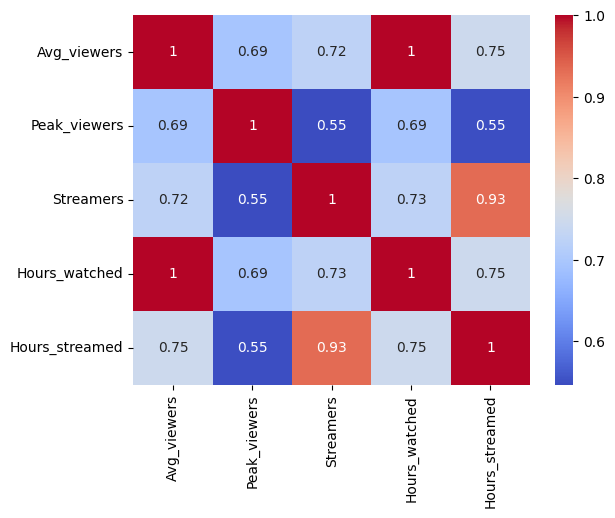

In [9]:
# Visualiser la corrélation entre les variables
correlation_matrix = df[['Avg_viewers', 'Peak_viewers', 'Streamers', 'Hours_watched', 'Hours_streamed']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Grâce à cette heatmap, nous pouvons voir les variables qui sont en corrélation avec les celulles de couleurs chaudes et un nombre proche de 1.
On peut donc ce concentrer sur les couples de variables : (Hours_watched, Avg_viewers) ou (Hours_streamed, Streamers)

In [10]:
# Analyser la corrélation entre les heures de diffusion et la popularité
hours_popularity_corr = df[['Hours_streamed', 'Avg_viewers']].corr().iloc[0, 1]
print(f"Corrélation entre les heures de diffusion et la popularité : {hours_popularity_corr}")

Corrélation entre les heures de diffusion et la popularité : 0.7456896284314831


Ici comme hours_popularity_corr est proche de 1, cela suggère une corrélation positive forte, indiquant que plus d'heures de diffusion sont généralement associées à un plus grand nombre moyen de téléspectateurs.

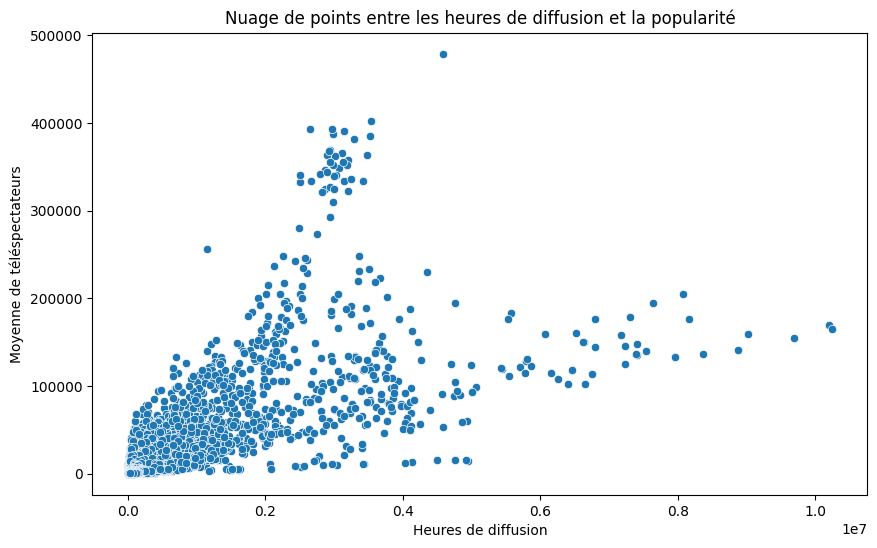

In [11]:
# Nuage de points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Hours_streamed', y='Avg_viewers', data=df)
plt.title('Nuage de points entre les heures de diffusion et la popularité')
plt.xlabel('Heures de diffusion')
plt.ylabel('Moyenne de téléspectateurs')
plt.show()

A INTERPRETER

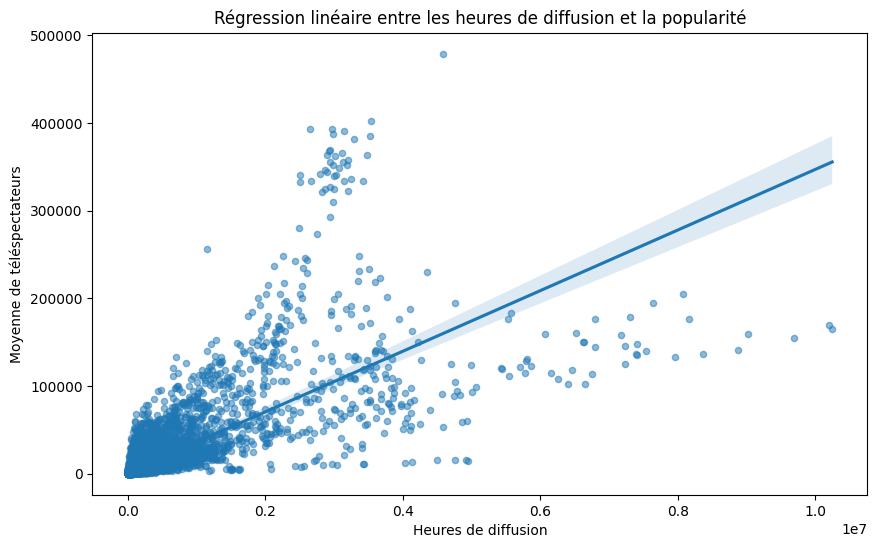

In [12]:
# Graphique de régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x='Hours_streamed', y='Avg_viewers', data=df, scatter_kws={'s': 20, 'alpha':0.5})
plt.title('Régression linéaire entre les heures de diffusion et la popularité')
plt.xlabel('Heures de diffusion')
plt.ylabel('Moyenne de téléspectateurs')
plt.show()

A INTERPRETER

### Comparaison entre les jeux en fonction de leur classement mensuel

### Analyse de la saisonnalité des jeux en fonction des mois de l'année

### Impact des heures de diffusions sur la popularité d'un jeu

## Conclusion